# Analyzing FBI NICS Firearm Background Checks

## Table of contents
1. [I. Data Wrangling](#wrangling)
    1. [US Census Data](#census)
    2. [NICS Data](#ncis)
2. [II. Data Analysis](#analysis) <br/>
    1. [Research Question 1](#rq1)<br/>
    2. [Research Question 2](#rq2)<br/>
    3. [Research Question 3](#rq3)<br/>
    4. [Research Question 4](#rq4)<br/>
    5. [Research Question 5](#rq5)<br/>
    6. [Research Question 6](#rq6)<br/>
    7. [Research Question 7](#rq7)<br/>
    8. [Research Question 8](#rq8)<br/>


<a name="overview"></a>
## I. Data Overview
Two data sets were used in this analysis:
1. **FBI's National Instant Criminal Background Check System:**<br/>
This data comes from the FBI's National Instant Criminal Background Check System.

  According to [FBI.gov](https://www.fbi.gov/services/cjis/nics):

> Mandated by the Brady Handgun Violence Prevention Act of 1993 and launched by the FBI on November 30, 1998, NICS is used by Federal Firearms Licensees (FFLs) to instantly determine whether a prospective buyer is eligible to buy firearms. Before ringing up the sale, cashiers call in a check to the FBI or to other designated agencies to ensure that each customer does not have a criminal record or isn’t otherwise ineligible to make a purchase. More than 230 million such checks have been made, leading to more than 1.3 million denials.

The background check data base records the number of background checks conducted *per month* in each of the 50 U.S. states and five U.S. territories from *November 1998 - March 2017*. Background checks relating to different transactions (purchase, rental, resale, pawning, etc.) and different gun types (hand gun, long gun, etc) are distinctly recorded.

The original dataset has footnotes among which include:
>These statistics represent the number of firearm background checks initiated through the NICS They **do not** represent the number of firearms sold Based on varying state laws and purchase scenarios, a one-to-one correlation cannot be made between a firearm background check and a firearm sale.

2. **U.S. Census Data**<br/>
This data comes from the US Census Bureau. It contains demographic statistics relating to economy, housing, race,etc. for each of the 50 states. Most variables just have one data point per state (2016), but a few have data for more than one year (e.g. for 2010).


<a name="wrangling"></a>
## III. Data Wrangling

### a. Data Acquisition

In [188]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as py


%matplotlib inline

In [189]:
# load and inspect data
census=pd.read_csv('ncis-and-census-data/census.csv')
gun_data=pd.read_excel('ncis-and-census-data/gun_data.xlsx')

### b. Data Cleansing

<a name="census"></a>
#### (i) U.S. Census Data

In [190]:
#explore census data
print(census.head(5))
print(census.tail(5))
print(census.info())

                                                Fact Fact Note    Alabama  \
0       Population estimates, July 1, 2016,  (V2016)       NaN  4,863,300   
1  Population estimates base, April 1, 2010,  (V2...       NaN  4,780,131   
2  Population, percent change - April 1, 2010 (es...       NaN      1.70%   
3                  Population, Census, April 1, 2010       NaN  4,779,736   
4  Persons under 5 years, percent, July 1, 2016, ...       NaN      6.00%   

    Alaska    Arizona   Arkansas  California   Colorado Connecticut Delaware  \
0  741,894  6,931,071  2,988,248  39,250,017  5,540,545   3,576,452  952,065   
1  710,249  6,392,301  2,916,025  37,254,522  5,029,324   3,574,114  897,936   
2    4.50%      8.40%      2.50%       5.40%     10.20%       0.10%    6.00%   
3  710,231  6,392,017  2,915,918  37,253,956  5,029,196   3,574,097  897,934   
4    7.30%      6.30%      6.40%       6.30%      6.10%       5.20%    5.80%   

      Florida     Georgia     Hawaii      Idaho    Illin

#### Preliminary Observations:
1. Data points are integer values with a string data type and so will need to be converted to a numeric data type.
2. Symbols like ( $ ) ( \% ) ( \, ) need to be removed for data type conversion noted above.
3. States are list in a *column* in the NICs data and in a *row* in the US Census data. The US Census data needs to be transposed so that the Census and Gun data sets are consistent.

#### U.S. Census Data Cleansing

In [191]:
#remove end notes from census file, transpose and trim
census_notes=census.iloc[66:,0:2]
census=census[:65]
census=census.T
census.columns=census.iloc[0,:]
census=census[2:]

In [192]:
#remove commas
census.replace({",": ""}, regex=True,inplace=True)

In [193]:
# remove symbols in data frame and change data type to float
for i in census.index:
    for j in census.columns:
        if census.loc[i,j][-1]=="%":
            census.loc[i,j]=float(census.loc[i,j].strip("%"))/100
        elif census.loc[i,j][0]=="$":
            census.loc[i,j]=float(census.loc[i,j].strip().strip("$"))
        else:
            census.loc[i,j]=pd.to_numeric(census.loc[i,j],errors='coerce')

In [194]:
#reset index
census=census.astype('float')
census.reset_index(inplace=True)
census.rename(columns={'index':'state'},inplace=True)
census=census.drop(census.columns[-1],axis=1)


<a name="ncis"></a>
#### (ii) NICS Data

In [195]:
print(gun_data.head(5))
print(gun_data.tail(5))
print(gun_data.info())

     month       state   permit  permit_recheck  handgun  long_gun   other  \
0  2017-09     Alabama  16717.0             0.0   5734.0    6320.0   221.0   
1  2017-09      Alaska    209.0             2.0   2320.0    2930.0   219.0   
2  2017-09     Arizona   5069.0           382.0  11063.0    7946.0   920.0   
3  2017-09    Arkansas   2935.0           632.0   4347.0    6063.0   165.0   
4  2017-09  California  57839.0             0.0  37165.0   24581.0  2984.0   

   multiple  admin  prepawn_handgun  prepawn_long_gun  prepawn_other  \
0       317    0.0             15.0              21.0            2.0   
1       160    0.0              5.0               2.0            0.0   
2       631    0.0             13.0               6.0            0.0   
3       366   51.0             12.0              13.0            0.0   
4         0    0.0              0.0               0.0            0.0   

   redemption_handgun  redemption_long_gun  redemption_other  \
0              1378.0             

#### Preliminary Observations:
1. The data ranges from 1998 to 2017 and observations are documented on a monthly basis. There are data points for each month except for the starting (1998) and ending (2017) years. These two years will therefore be excluded from the analysis to ensure consistent number of months per year in NICs data.
2. NICs data records background checks and is a proxy for sales.
3. According to the [Small Arms Survey]

> *"The magnitude of the demand for firearms in the United States can be approximated if one is willing to make two assumptions: firstly, that all permit checks are routine procedural checks by states against FBI records and are not associated with an intent to purchase a gun; and, secondly, that all in-store (retailer) checks by licensed firearms dealers against FBI records result in at least one firearms purchase.*

> *As approximations go, one may then add ‘handgun’ checks, plus ‘long gun’ checks, plus two ‘multiple’ checks (at least one handgun and one long gun), and augment the resulting number by a factor of 1.1, termed here the multiple gun sales factor (MGSF)."*

Accordingly, only the columns hand gun, long gun and multiple (gun) will be used in the analysis. Estimated total gun sales will be calculated as follows:

$Estimated \ Total \ Sales=[ (Hand \ Gun+Long \ Gun)+(Multiple∗2) ]∗1.1$
 


#### NICS Data Cleansing

In [196]:
#select only relevant columns based on small arms survey
gun_trimmed=gun_data[gun_data.columns[np.r_[0,1,4,5,7]]]


#create columns for month and year
gun_trimmed.rename(columns={'month':'year_month'},inplace=True)
gun_trimmed.loc[:,'year']=gun_trimmed['year_month'].map(lambda x: x[:-3])
gun_trimmed.loc[:,'month']=gun_trimmed['year_month'].map(lambda x: x[-2:])
gun_trimmed.loc[:,'year']=gun_trimmed.loc[:,'year'].astype('int64')


#drop start and ending years with incomplete data
gun_trimmed=gun_trimmed.query('year>1998 and year<2017')

/Users/hazam/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/hazam/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [197]:
#rearrange column names
cols=gun_trimmed.columns.tolist()
cols=cols[-2:]+cols[:-2]
gun_trimmed=gun_trimmed[cols]
gun_trimmed.columns

Index(['year', 'month', 'year_month', 'state', 'handgun', 'long_gun',
       'multiple'],
      dtype='object')

In [198]:
#calculate estimated total sales based on Small Arms Survey research
gun_trimmed['sales_estimate']=1.1*(gun_trimmed['handgun']+gun_trimmed['long_gun']+gun_trimmed['multiple']*2)


<a name="analysis"></a>
## II. Data Analysis

<a name="rq1"></a>
### Research Question 1
*What is the distrubtion of the interest in the three gun types as of 2016 across the 50 states in the United States?*

#### Methodology:

1. Only gun data for 2016 will be examined and the five U.S territories will be excluded.

In [199]:
fig, ax = py.subplots(figsize = (50,24))
territories=['District of Columbia','Mariana Islands','Guam','Puerto Rico','Virgin Islands']
sns.barplot(x='state',y='sales_estimate',data=gun_trimmed.query('year==2016 & state!=@territories'))
py.xticks(rotation=45,fontsize=24)
py.yticks(fontsize=24);
py.xlabel('State',fontsize=40)
py.ylabel('Estimated Gun Sales',fontsize=40)
py.title('Estimated Gun Sales Landscape Across the United States in 2016',  fontsize=50)
py.savefig("gun_sales_landscape.png")
           

<a name="rq2"></a>
### Research Question 2
*What is the population distrubtion across the United States as of 2016?*

#### Methodology:

1. Only data for 2016 will be examined and the census data set will be leveraged.

In [200]:
fig, ax = py.subplots(figsize = (50,24))
d=census.iloc[:,[0,1]]
d.rename(columns={d.columns[1]:'population'},inplace=True)
g=sns.barplot(x='state',y='population',data=d)
py.xticks(rotation=45,fontsize=24)
py.yticks(fontsize=24)
py.ticklabel_format(style='plain', axis='y')
py.xlabel('State',fontsize=40)
py.ylabel('Population',fontsize=40)
py.title('US Population Distribution by State - 2016',  fontsize=50);
py.savefig("dist_pop.png")

<a name="rq3"></a>
### Research Question 3
*What is the estimated gun sales distrubtion across the United States as of 2016?*

#### Methodology:

1. Only data for 2016 will be examined to construct a distribution plot of estimated gun sales.

In [201]:
fig, ax = py.subplots(figsize = (10,5))
g=sns.distplot(gun_trimmed.query('year==2016').sales_estimate, color='green');
py.xlabel('Sales Estimate')
py.title('Estimated Gun Sales Distribution - 2016');
py.savefig("gun_sales_dist.png")        

<a name="rq4"></a>
### Research Question 4
*Which states had the highest and lowest estimated guns per capita?*

#### Methodology:

1. Guns per capita is calculated as follows:
> $Guns \ per \ Capita= \frac{Estimated \ Gun \ Sales}{Population}$
 
    Guns per capita will only be calculated for the two years that census population data is available - 2010 and 2016.
    
<br/>
2. NICS and US Census data will be merged on state to create a new data frame with an additional column for guns per capita.

In [202]:
#gun sales for 2010 and 2016
gun_10_16=gun_trimmed.loc[:,['state','year','sales_estimate']].query('year==["2010","2016"]').groupby(['state','year'], as_index=False).sum()
gun_10_16.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110 entries, 0 to 109
Data columns (total 3 columns):
state             110 non-null object
year              110 non-null int64
sales_estimate    110 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.4+ KB


In [203]:
#population data for 2010 and 2016
p16=census.iloc[:,[0,1]]
p16.loc[:,'year'] = [2016] * (len(p16))
p16.rename(columns={p16.columns[1]:'population'},inplace=True)
p10=census.iloc[:,[0,2]]
p10.loc[:,'year'] = [2010] * (len(p10))
p10.rename(columns={p10.columns[1]:'population'},inplace=True)
population=pd.concat([p10,p16],ignore_index=True)

In [204]:
#merge gun sales with population
gun_census=pd.merge(population,gun_10_16,left_on=['state','year'],right_on=['state','year'],how='inner')
gun_cols=gun_census.columns.tolist()
gun_census=gun_census[gun_cols[2:3]+gun_cols[0:2]+gun_cols[3:]]
gun_census.loc[:,'guns_per_capita']=gun_census['sales_estimate']/gun_census['population']

In [205]:
#five states with the highest guns per capita in 2016
gun_census.loc[gun_census.loc[gun_census.year==2016,"guns_per_capita"].nlargest(5).index,:]

,year,state,population,sales_estimate,guns_per_capita
51,2016,Alaska,741894.0,86911.0,0.117147
90,2016,South Dakota,865454.0,99451.0,0.114912
97,2016,West Virginia,1831102.0,202174.5,0.110411
75,2016,Montana,1042520.0,109710.7,0.105236
99,2016,Wyoming,585501.0,56071.4,0.095767


In [206]:
#five states with the highest guns per capita in 2010
gun_census.loc[gun_census.loc[gun_census.year==2010,"guns_per_capita"].nlargest(5).index,:]

,year,state,population,sales_estimate,guns_per_capita
1,2010,Alaska,710249.0,68128.5,0.095922
25,2010,Montana,989414.0,85250.0,0.086162
40,2010,South Dakota,814195.0,66053.9,0.081128
47,2010,West Virginia,1853011.0,141483.1,0.076353
49,2010,Wyoming,563767.0,41484.3,0.073584


In [207]:
#five states with the highest guns per capita across 2010 and 2016
gun_census.loc[gun_census["guns_per_capita"].nlargest(5).index,:]

,year,state,population,sales_estimate,guns_per_capita
51,2016,Alaska,741894.0,86911.0,0.117147
90,2016,South Dakota,865454.0,99451.0,0.114912
97,2016,West Virginia,1831102.0,202174.5,0.110411
75,2016,Montana,1042520.0,109710.7,0.105236
1,2010,Alaska,710249.0,68128.5,0.095922


In [208]:
#five states with the lowest guns per capita in 2016
gun_census.loc[gun_census.loc[gun_census.year==2016,"guns_per_capita"].nsmallest(5).index,:]

,year,state,population,sales_estimate,guns_per_capita
60,2016,Hawaii,1428557.0,0.0,0.000000
64,2016,Iowa,3134693.0,42002.4,0.013399
79,2016,New Jersey,8944469.0,131282.8,0.014678
76,2016,Nebraska,1907116.0,31212.5,0.016366
81,2016,New York,19745289.0,369475.7,0.018712


In [209]:
#five states with the lowest guns per capita in 2010
gun_census.loc[gun_census.loc[gun_census.year==2010,"guns_per_capita"].nsmallest(5).index,:]


,year,state,population,sales_estimate,guns_per_capita
10,2010,Hawaii,1360301.0,0.0,0.000000
29,2010,New Jersey,8791953.0,56541.1,0.006431
20,2010,Massachusetts,6547813.0,63191.7,0.009651
31,2010,New York,19378110.0,230125.5,0.011876
14,2010,Iowa,3046869.0,45188.0,0.014831


In [210]:
#five states with the lowest guns per capit across 2010 and 2016
gun_census.loc[gun_census["guns_per_capita"].nsmallest(5).index,:]

,year,state,population,sales_estimate,guns_per_capita
10,2010,Hawaii,1360301.0,0.0,0.000000
60,2016,Hawaii,1428557.0,0.0,0.000000
29,2010,New Jersey,8791953.0,56541.1,0.006431
20,2010,Massachusetts,6547813.0,63191.7,0.009651
31,2010,New York,19378110.0,230125.5,0.011876


In [211]:
#hawaii appears to only carry out permit checks
gun_data[gun_data.state=="Hawaii"].head()

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,prepawn_long_gun,prepawn_other,redemption_handgun,redemption_long_gun,redemption_other,returned_handgun,returned_long_gun,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
12,2017-09,Hawaii,946.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,948
67,2017-08,Hawaii,1077.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1079
122,2017-07,Hawaii,1107.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1109
177,2017-06,Hawaii,1082.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1083
232,2017-05,Hawaii,1114.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1117


<a name="rq5"></a>
### Research Question 5
*Which variable in the Census Data has the highest correlation with estimated guns per capita?*


#### Methodology:
1. 2010 and 2016 guns per capita will be analyzed separately.
2. The 2010 estimated guns per capita should be compared with:<br/>
   a) all census variables (for consistency when comparing the results of the correlation analysis of the 2016 estimated gun sales).
   <br/> 
   b) census variables only relating to 2010

**a) Correlation between Estimated Guns per Capita in 2010 and US Census**

In [212]:
#merge estimated guns per capita in 2010 with US census data
g10=gun_census.query('year=="2010"').loc[:,['state','guns_per_capita']]
gc10_1=pd.merge(census,g10,how='inner',on='state')


#calculate the correlation coefficient between guns per capita in 2010 and all census variables 
c10_1=gc10_1[gc10_1.columns[1:]].corr(method='pearson')['guns_per_capita'][:-1]
ac10_1=abs(c10_1)
correlations_10_1=pd.DataFrame({'corr_10': c10_1, 'abs_corr_10': ac10_1})

In [213]:
#census variable with the highest correlation to guns per capita in 2010 
correlations_10_1.loc[correlations_10_1['abs_corr_10'].idxmax()]

corr_10       -0.618973
abs_corr_10    0.618973
Name: Foreign born persons, percent, 2011-2015, dtype: float64

**b) Correlation between Estimated Guns per Capita in 2010 and US Census 2010**

In [214]:
#extract census variables for 2010
c10_cols=census.loc[:,census.columns.str.contains('2010')].columns.tolist()
c10_cols[0]='state'
c10=census[c10_cols]


#merge estimated guns per capita in 2010 with US Census data for 2010
gc10_2=pd.merge(c10,g10,how='inner',on='state')



#calculate the correlation coefficient between guns per capita in 2010 and 2010 census variables 
c10_2=gc10_2[gc10_2.columns[1:]].corr(method='pearson')['guns_per_capita'][:-1]
ac10_2=abs(c10_2)
correlations_10_2=pd.DataFrame({'corr_10': c10_2, 'abs_corr_10': ac10_2})

In [215]:
#2010 census variable with the highest correlation to guns per capita in 2010 
correlations_10_2.loc[correlations_10_2['abs_corr_10'].idxmax()]

corr_10       -0.55689
abs_corr_10    0.55689
Name: Population per square mile, 2010, dtype: float64

**c) Correlation between Estimated Guns per Capita in 2016 and US Census**

In [216]:
#merge estimated guns per capita in 2016 with US census data
g16=gun_census.query('year=="2016"').loc[:,['state','guns_per_capita']]
gc16=pd.merge(census,g16,how='inner',on='state')


c16=gc16[gc16.columns[1:]].corr()['guns_per_capita'][:-1]
ac16=abs(gc16[gc16.columns[1:]].corr()['guns_per_capita'][:-1])
correlations_16=pd.DataFrame({'corr': c16, 'abs_corr': ac16})

In [217]:
correlations_16.loc[correlations_16['abs_corr'].idxmax()]

corr       -0.618576
abs_corr    0.618576
Name: Foreign born persons, percent, 2011-2015, dtype: float64

**d) Correlation Plots**

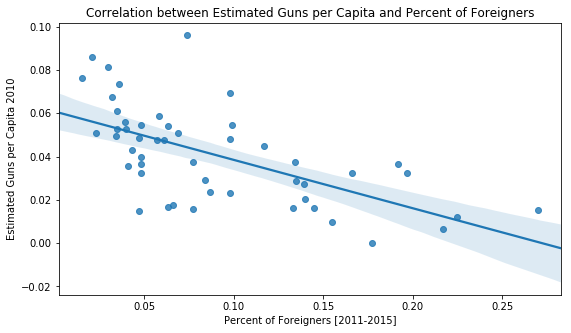

In [218]:
#census variable with the highest correlation to guns per capita in 2010 
fig, ax = py.subplots(figsize = (9,5))
sns.regplot(gc10_1['Foreign born persons, percent, 2011-2015'],gc10_1['guns_per_capita'])
py.title('Correlation between Estimated Guns per Capita and Percent of Foreigners')
py.xlabel('Percent of Foreigners [2011-2015]')
py.ylabel('Estimated Guns per Capita 2010')
py.savefig('correlation_1.png')


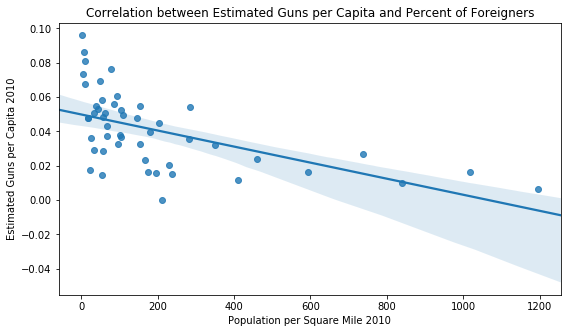

In [219]:
#2010 census variable with the highest correlation to guns per capita in 2010 
fig, ax = py.subplots(figsize = (9,5))
sns.regplot(gc10_2['Population per square mile, 2010'],gc10_2['guns_per_capita'])
py.title('Correlation between Estimated Guns per Capita and Percent of Foreigners')
py.xlabel('Population per Square Mile 2010')
py.ylabel('Estimated Guns per Capita 2010')
py.savefig('correlation_2.png')


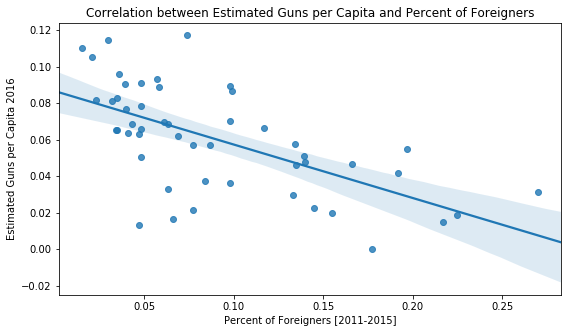

In [220]:
#census variable with the highest correlation to guns per capita in 2016 
fig, ax = py.subplots(figsize = (9,5))
sns.regplot(gc16['Foreign born persons, percent, 2011-2015'],gc16['guns_per_capita'])
py.title('Correlation between Estimated Guns per Capita and Percent of Foreigners')
py.xlabel('Percent of Foreigners [2011-2015]')
py.ylabel('Estimated Guns per Capita 2016')
py.savefig('correlation_3.png')

<a name="rq6"></a>
### Research Question 6
*Which states at the highest rate of growth in estimated gun sales?*

#### Methodology:
1. Compound Annual Growth Rate will be used to measure growth in estimated gun sales between 1999 and 2016 Compound Annual Growth Rate was chosen because it dampens the effect of volatility of periodic sales.
> $CAGR= (\frac {Last Year Sales}{First Year Sales})^{1/n} − 1$
    > <br/>
    where $n$ is the number of years

In [221]:
#extract gun sales for the first and last year for each state
first_year=gun_trimmed[gun_trimmed['year']==1999].loc[:,['state','sales_estimate','year_month']]
first_year=first_year.groupby(['state']).sum()['sales_estimate']
last_year=gun_trimmed[gun_trimmed['year']==2016].loc[:,['state','sales_estimate','year_month']]
last_year=last_year.groupby(['state']).sum()['sales_estimate']


#calculate CAGR for each state
growths=pd.DataFrame({'first_year':first_year,'last_year':last_year,'ratio':last_year/first_year})
growths['ratio']=((growths['last_year']/growths['first_year'])**(1/18))-1
growths=growths.replace(np.inf,np.nan)

#identify states with the five highest CAGRs 
growths.sort_values(by='ratio',ascending=False).head(5)

,first_year,last_year,ratio
state,,,
District of Columbia,23.1,812.9,0.218744
Guam,193.6,2247.3,0.145917
Massachusetts,21639.2,135154.8,0.107132
Florida,292213.9,1131706.4,0.078123
Connecticut,49908.1,182806.8,0.074789


<a name="rq7"></a>
### Research Question 7
*What are trends in estimated gun sales over time?*


#### Methodology:

1. Aggregate the estimated sales across each state to show the overall trend in estimated gun sales between 1999 and 2016 in America.
2. Adjust for seasonality by using the rolling method whch splits the data into windows of time (in this case each window will be a period of 12 months). The data in each window is then aggregated calculating the mean. The windows overlap and 'roll' at the same frequency as the data so the transformed time series is at the same frequency as the original time series. Adjusting for seasonality smooths out periodic fluctuations in the data to observe long term trends.

In [222]:
import matplotlib.dates as mdates
sales_by_year=gun_trimmed.groupby(['year_month']).sum()['sales_estimate'].astype('int64')
sales_by_year=pd.DataFrame({'year_month':sales_by_year.index,
                            'sales':sales_by_year}).reset_index(drop=True)


In [223]:
sales_by_year['seasonally_adjusted']=sales_by_year['sales'].rolling(window=12, center=True, min_periods=12).mean().fillna(0).astype("int32")
sales_by_year['year_month']=pd.to_datetime(sales_by_year['year_month'])


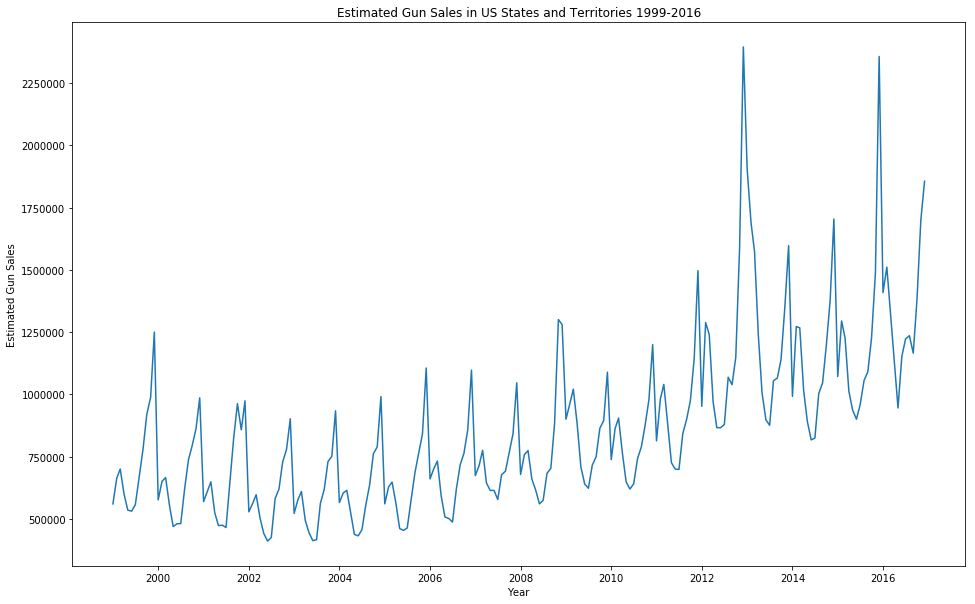

In [224]:
#Unadjusted for seasonality

fig, ax = py.subplots(figsize = (16,10))
sns.lineplot(x="year_month", y="sales", data=sales_by_year)
py.title('Estimated Gun Sales in US States and Territories 1999-2016')
py.xlabel('Year')
py.ylabel('Estimated Gun Sales')
py.savefig("trend_unadjusted.png")


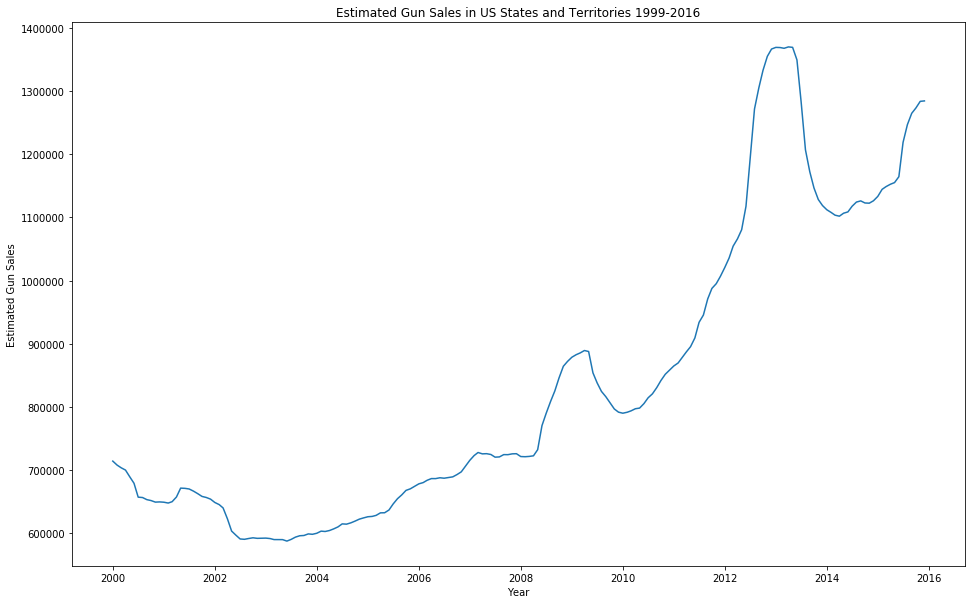

In [225]:
#Seasonally adjusted

fig, ax = py.subplots(figsize = (16,10))
sales_by_year=sales_by_year[sales_by_year["year_month"]>'1999-12-01']
sales_by_year=sales_by_year[sales_by_year["year_month"]<'2016-01-01']
sns.lineplot(x="year_month", y="seasonally_adjusted", data=sales_by_year)
py.title('Estimated Gun Sales in US States and Territories 1999-2016')
py.xlabel('Year')
py.ylabel('Estimated Gun Sales')
py.savefig("seasonally_adjusted.png")


<a name="rq8"></a>
### Research Question 8:
*What is the seasonal (monthly) trend in estimated gun sales?* 


#### Methodology:
1. Group the estimated gun sales by month and sum across each state and year to capture the change in estimated gun sale
s across a year.

In [226]:
gun_trimmed.rename(columns={'month':'month_date'},inplace=True)
gun_trimmed['month']=gun_trimmed['month_date'].apply(lambda x: x[-2:])
In [555]:


SyntaxError: invalid syntax (<ipython-input-226-1a3356220f54>, line 3)

In [ ]:
sales_month=gun_trimmed.groupby(['month']).sum()['sales_estimate'].reset_index()


sales_month=pd.DataFrame({'sales':sales_month['sales_estimate'],
                               'month_int':sales_month['month']
                              })

sales_month["month_name"]=pd.to_datetime(sales_month['month_int'], format='%m').dt.month_name().str.slice(stop=3)
py.figure(figsize=(16, 10))
sns.lineplot(x="month_name", y="sales", data=sales_month,sort=False).set(xticks=sales_month.month_name.values);
py.title('Estimated Gun Sales by Month between 1998-2016')
py.ylabel('Estimtaed Gun Sales in Millions')
py.xlabel('Month')
py.savefig("monthly_trend.png")


<a name="conclusions"></a>
## V. Conclusions

<a name="ans1"></a>
**1. What is the distrubtion of the interest in the three gun types as of 2016 across the 50 states in the United States?**


>This cursory outlook indicates that the gun sales landscape is dominated by California and Texas. This leads to a potential hypothesis that state population plays a significant role in estimated gun sales in comparison to factors like political affiliation (red vs blue) as Texas and California have the highest state population but opposing political associations.

![](gun_sales_landscape.png)

<a name="ans2"></a>
**2. What is the population distrubtion across the United States as of 2016?**
![](dist_pop.png)


<a name="ans3"></a>
**3. What is the estimated gun sales distrubtion across the United States as of 2016?**

>The distribution of estimated gun sales in 2016 is skewed to the right. The concentration of estimated gun sales appears to collect around the lower end of the distribution.

![](gun_sales_dist.png)

<a name="ans4"></a>
**4. Which state in America has the highest and lowest estimated guns per capita?**


|Year|Highest Guns per Capita|Lowest Guns Per Capita|
|----|----|----|
|2010|Alaska (0.0959)|New Jersey (0.0064)|
|2016|Alaska (0.1171)|Iowa (0.0134)|


> a) **Alaska** has the highest gun per capita in both 2010 and 2016. Moreover, the gun per capita increased from **0.0959** in 2010 to **0.1171** in 2016.
<br/>
<br/>
> b) **New Jersey** had the lowest gun per capita in 2010 of **0.0064**.
<br/>
<br/>
> c) **Iowa** had the lowest gun per capita in 2016 of **0.0134**.
<br/>
<br/>
> Again, the lowest gun per capita value rose between 2010 and 2016. 
<br/>
<br/>
> *Note - Hawaii had an estimated gun per capita of 0 in both 2010 and 2016 because all its background checks were conducted as permit checks or rechecks. As a result this state was excluded from this part of the analysis because permit checks were not incorporated in the estimation of guns per capita.*

<a name="ans5"></a>
**5. Which popultation statistic is has the highest correlation with estimated guns per capita in America?** 
<br/>
<br/>

> a) **Percent of Foreigners 2011-2015** has the highest (negative) correlation of **-0.6190** to estimated guns per capita in 2010 from the whole census data set.

![](correlation_1.png)

> b) **Population per Square Mile 2010** has the highest (negative) correlation of **-0.5569** to estimated guns per capita in 2010 from subset of census data relating to 2010.

![](correlation_2.png)

> c) **Percent of Foreigners 2011-2015** has the highest (negative) correlation of **-0.6186** to estimated guns per capita in 2016 from the whole census data set.

![](correlation_3.png)


<a name="ans6"></a>
**6. Which state in America has reported the highest rate of growth in estimated gun sales?**

> a) **Districut of Columbia** is the U.S. territory with the highest growth (per CAGR) of estimated gun sales at **21.87%**.
<br/>
<br/>
b) **Massachusetts** is the U.S. state with the highest growth (per CAGR) of estimated gun sales at **10.71%**.


<a name="ans7"></a>
**7. What trends can be observed in estimated gun sales over time in America?**

There is an exponential increase in the estimated gun sales over time in America between 1998-2016. Major points of inflection include:<br/>
<br/>
>**2001:** The year of the 9/11 attacks.<br/>
**2009:** The first year President Obamas took office.<br/>
**2013:** The year of President Obama's call for stricter gun laws after a mass shooting at Sandy Hook Elementary School at the end of 2012.**

\** Source: *[New York Times](https://www.nytimes.com/interactive/2015/12/10/us/gun-sales-terrorism-obama-restrictions.html)*

##### Trend in Estimated Gun Sales [1999-2016]
![](trend_unadjusted.png)

##### Seasonally Adjusted Trend in Estimated Gun Sales [1999-2016]
![](seasonally_adjusted.png)

<a name="ans5"></a>
**5. What is the seasonal (monthly) trend in estimated gun sales?**
> There is a significant spike in the estimated gun sales in the month of **December**. It should be noted that the events listed above in (4) all occured around December.

![](monthly_trend.png)